In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [3]:
df = pd.read_csv("data\consumption_temp.csv")
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

8641
8641
8641
8641
8641
6289


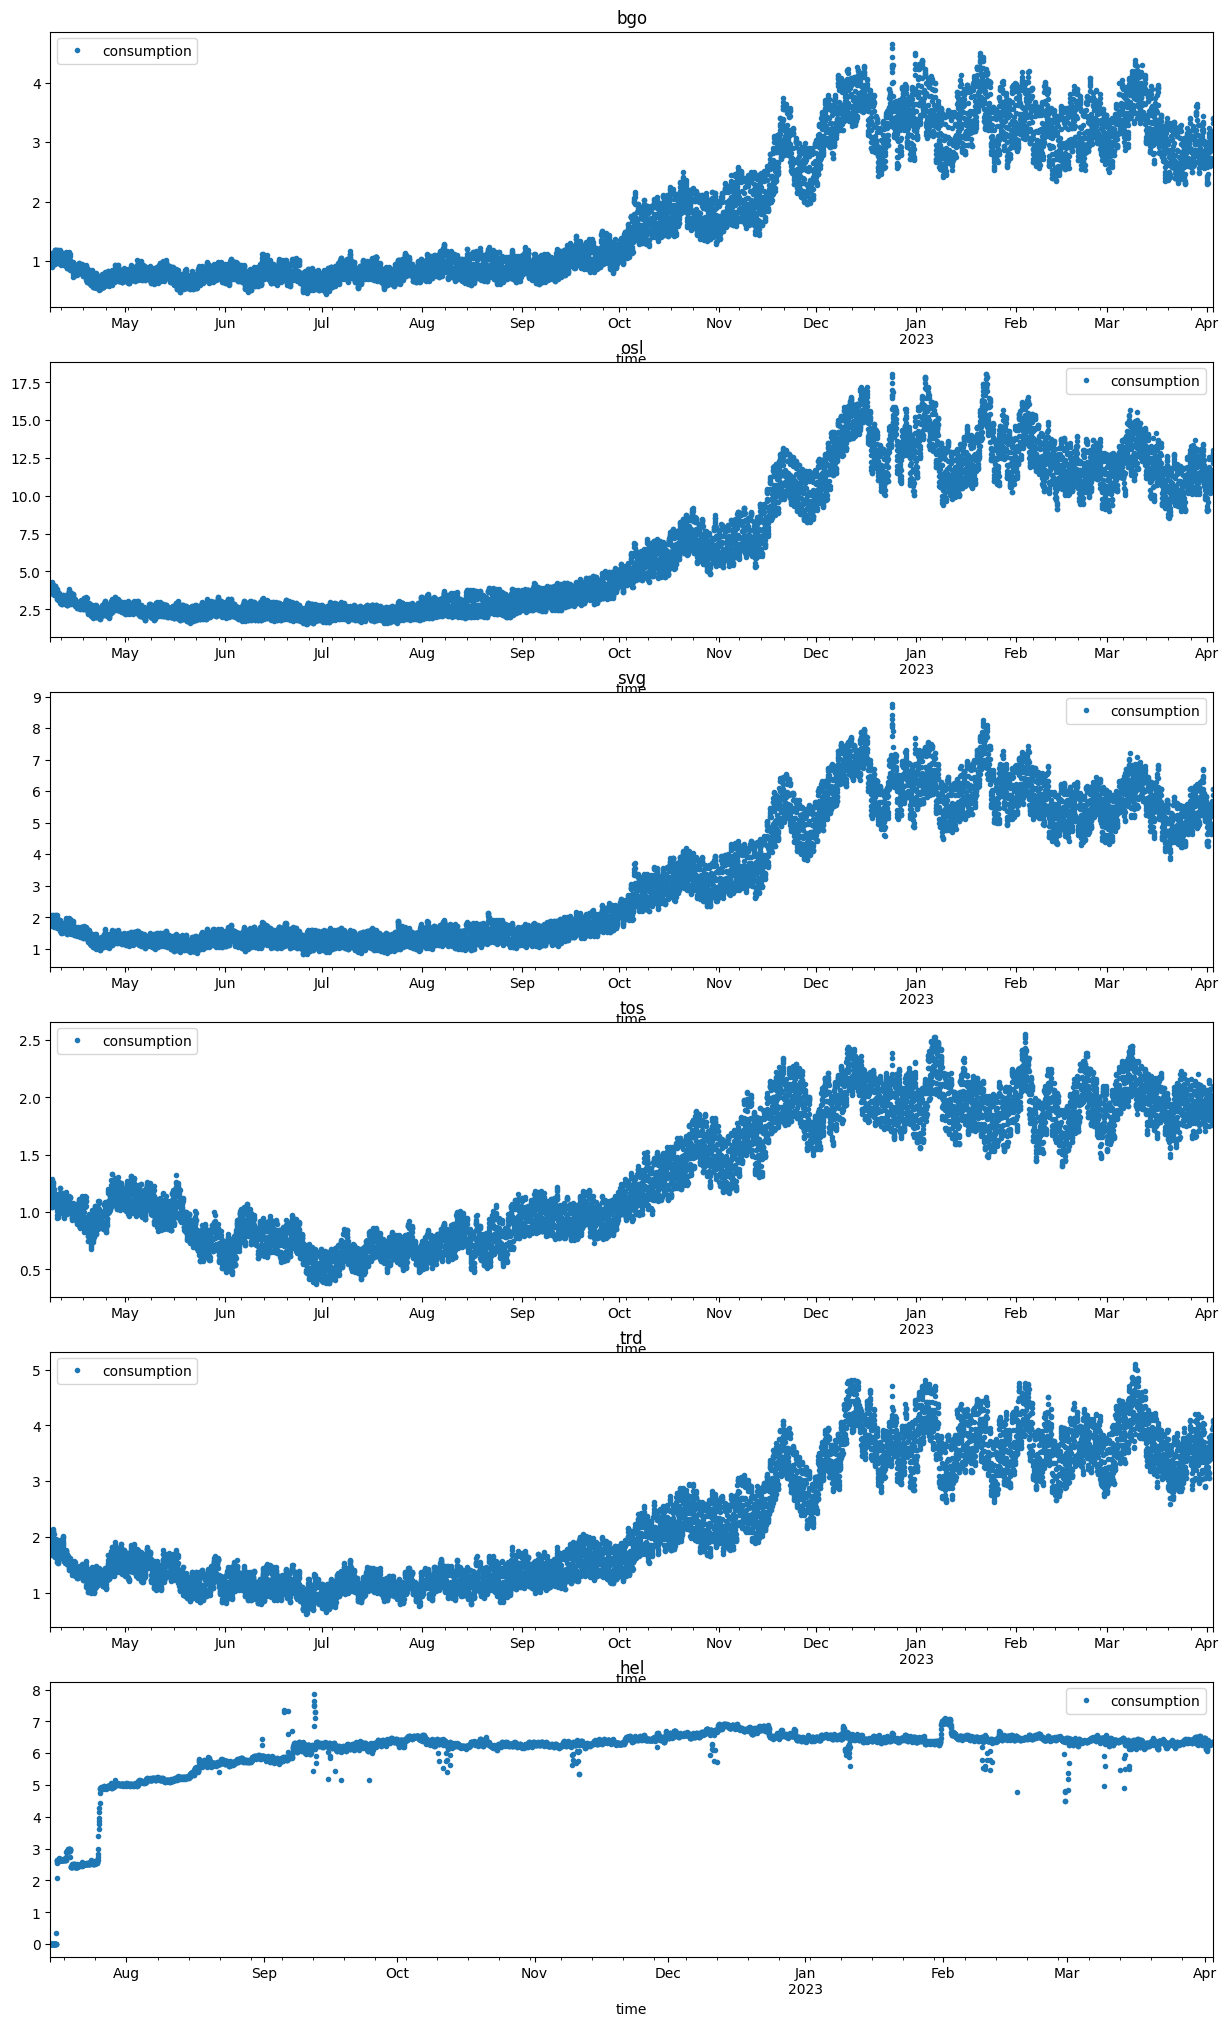

In [4]:
bgo = df.query('location == "bergen"')
osl = df.query('location == "oslo"')
svg = df.query('location == "stavanger"')
tos = df.query('location == "tromsø"')
trd = df.query('location == "trondheim"')
hel = df.query('location == "helsingfors"')

locations = [bgo, osl, svg, tos, trd, hel]

fig, axs = plt.subplots(6, 1, figsize=(15,25), sharex=False)
bgo[["consumption", ]].plot(ax=axs[0], title="bgo", style=".")
osl[["consumption",]].plot(ax=axs[1], title="osl", style=".")
svg[["consumption",]].plot(ax=axs[2], title="svg", style=".")
tos[["consumption", ]].plot(ax=axs[3], title="tos", style=".")
trd[["consumption",]].plot(ax=axs[4], title="trd", style=".")
hel[["consumption", ]].plot(ax=axs[5], title="hel", style=".")

for df in locations:
    print(df.shape[0])


## Simple train/test split

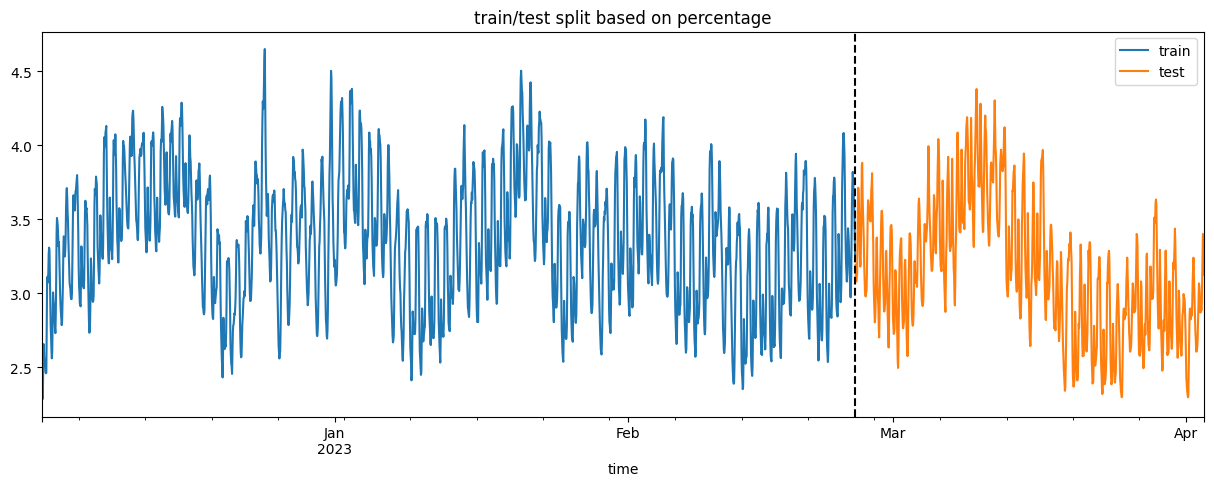

In [5]:
# only use 2023 data
bgo = bgo.query('time > "12-2022"')

# Determine the split point
split_idx = int(len(bgo) * 0.7)

# Split the data
train = bgo.iloc[:split_idx]
test = bgo.iloc[split_idx:]

# Plot the data
fig, ax = plt.subplots(figsize=(15,5))
train["consumption"].plot(ax=ax, label="train", title="train/test split based on percentage")
test["consumption"].plot(ax=ax, label="test")
ax.axvline(train.index[-1], color="black", ls="--")
ax.legend(["train", "test"])
plt.show()


<Axes: title={'center': 'One week of data'}, xlabel='time'>

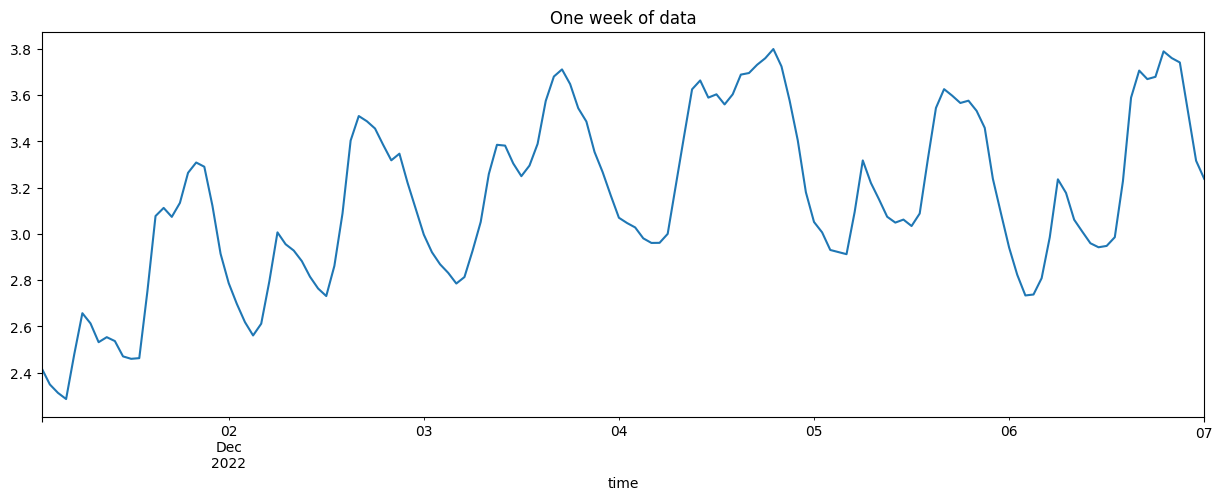

In [6]:
bgo.loc[(bgo.index > "12-01-2022") & (bgo.index <= "12-07-2022")]["consumption"].plot(
    figsize=(15,5), title="One week of data"
)

## Cross Validation split

In [7]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=589, gap=24*5)
tss

TimeSeriesSplit(gap=120, max_train_size=None, n_splits=4, test_size=589)

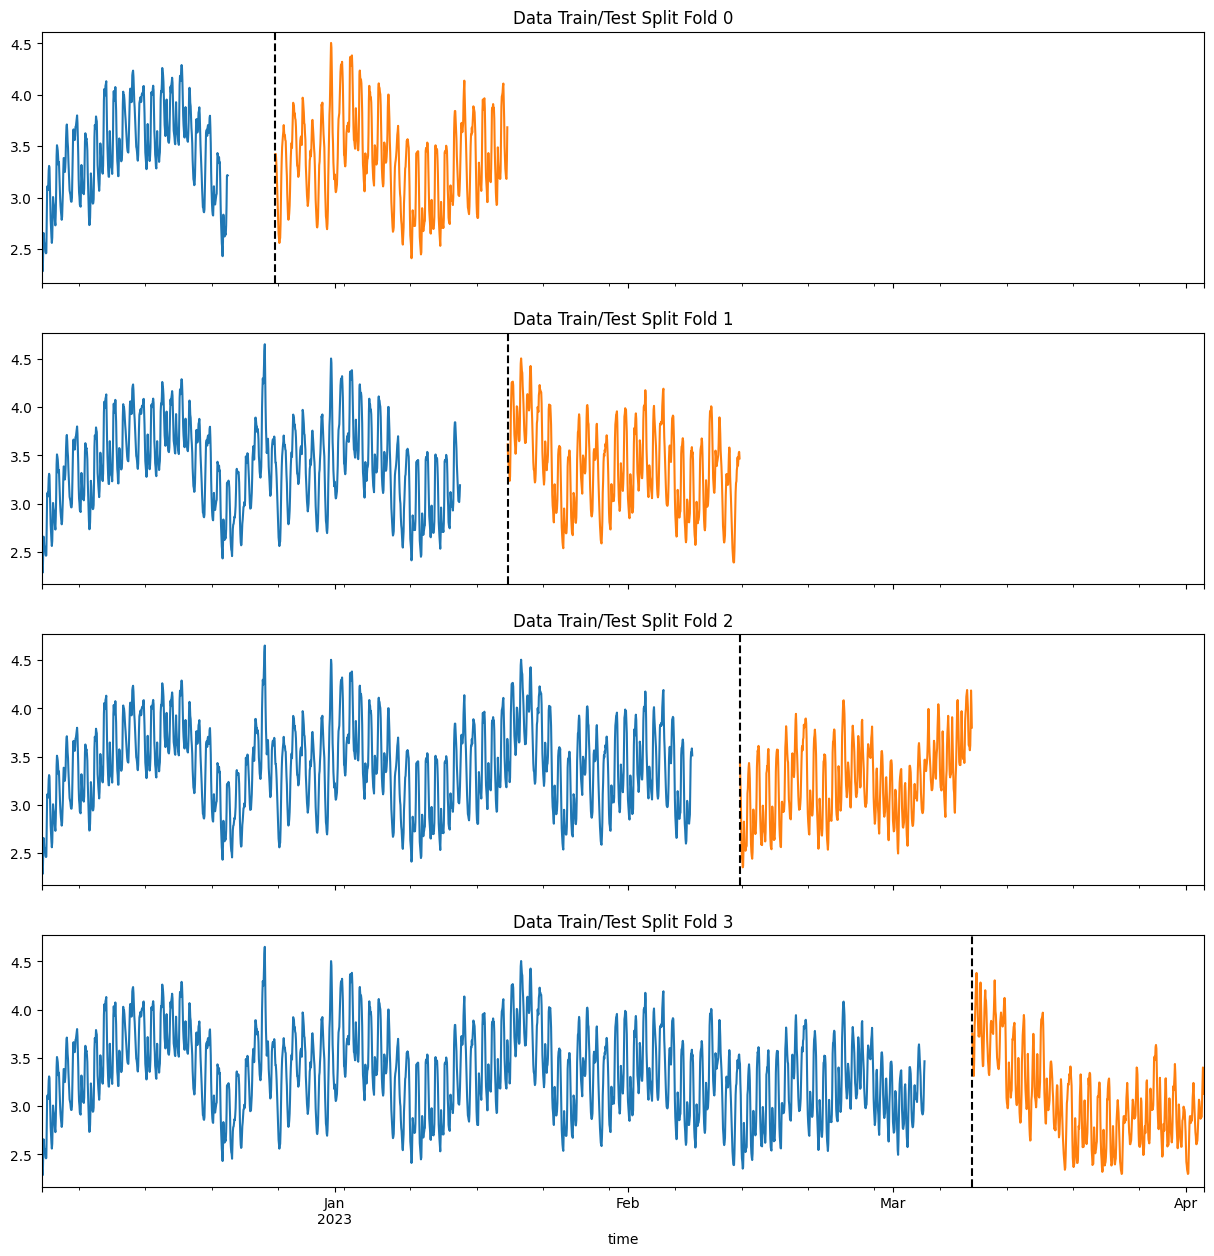

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(bgo):
    train = bgo.iloc[train_idx]
    test = bgo.iloc[val_idx]
    train['consumption'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['consumption'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Model Creation

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Creating daily lag features for up to 3 days
    for lag in range(24, 24*3, 24):
        df['lag_daily_' + str((lag))] = df['consumption'].shift(lag)
    # Rolling standard deviation
    df['rolling_std_1d'] = df['consumption'].rolling(window=24).std()
    df.dropna(inplace=True)
   
    return df

## Train Using Cross-Validation

In [10]:
tss = TimeSeriesSplit(n_splits=4, test_size=589, gap=24*5)
bgo = bgo.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(bgo):
    train = bgo.iloc[train_idx]
    test = bgo.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ["hour", "dayofyear", "temperature", "lag_daily_24", "rolling_std_1d"]
    TARGET = 'consumption'
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=200)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:3.00391	validation_1-rmse:2.87476


[200]	validation_0-rmse:0.43623	validation_1-rmse:0.52477
[400]	validation_0-rmse:0.12505	validation_1-rmse:0.28206
[600]	validation_0-rmse:0.09729	validation_1-rmse:0.25841
[693]	validation_0-rmse:0.09180	validation_1-rmse:0.25774
[0]	validation_0-rmse:2.91279	validation_1-rmse:2.84102
[200]	validation_0-rmse:0.43122	validation_1-rmse:0.48533
[400]	validation_0-rmse:0.15133	validation_1-rmse:0.25085
[600]	validation_0-rmse:0.12806	validation_1-rmse:0.23162
[800]	validation_0-rmse:0.12072	validation_1-rmse:0.22923
[977]	validation_0-rmse:0.11504	validation_1-rmse:0.22810
[0]	validation_0-rmse:2.92058	validation_1-rmse:2.75490
[200]	validation_0-rmse:0.43547	validation_1-rmse:0.41038
[400]	validation_0-rmse:0.16848	validation_1-rmse:0.19256
[585]	validation_0-rmse:0.14798	validation_1-rmse:0.18483
[0]	validation_0-rmse:2.85150	validation_1-rmse:2.51417
[200]	validation_0-rmse:0.42770	validation_1-rmse:0.31106
[341]	validation_0-rmse:0.19276	validation_1-rmse:0.22742


In [11]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.2232
Fold scores:[0.2570456619407415, 0.22799834933895702, 0.1848126634604906, 0.2230783344228455]


In [ ]:
train = create_features(train)
test = create_features(test)

In [ ]:

"""
    For original model, without 5 days of data missing
"""
# FEATURES = ["hour", "dayofyear", "temperature", "lag_daily_24", "rolling_std_1d"]
# TARGET = 'consumption'

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       subsample=0.8,
                       )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

## Feature Importance

In [ ]:

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
test['prediction'] = reg.predict(X_test)
test.head()
bgo = bgo.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = bgo[['consumption']].plot(figsize=(15, 5), style="-")
bgo['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
ax = bgo.loc[(bgo.index > '03-01-2023') & (bgo.index < '03-07-2023')]['consumption'] \
    .plot(figsize=(15, 5), title='Week Of Data')
bgo.loc[(bgo.index > '03-01-2023') & (bgo.index < '03-07-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

ax = bgo.loc[(bgo.index > '04-01-2018') & (bgo.index < '04-08-2018')]['consu'] \
    .plot(figsize=(15, 5), title='Week Of Data')
bgo.loc[(bgo.index > '04-01-2018') & (bgo.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['consumption'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)